## Lecture 9 : Deep Neural Operators

## Table of Contents
#### 1. [DeepONet for Antiderivative Operators in TF2.0](#DeepONet-for-Antiderivative-Operators-in-TF2.0)
#### 1. [DeepONet for Antiderivative Operators in JAX](#DeepONet-for-Antiderivative-Operators-in-JAX)
#### 2. [FNO for Burger's Equation](#Fourier-Neural-Operator-(FNO)-for-Burgers-Equation)

## DeepONet for Antiderivative Operators in TF2.0

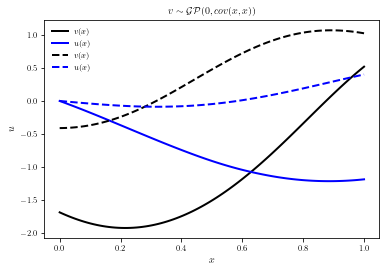

In [2]:
import tensorflow.compat as tf
import numpy as np
import scipy.io as io
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io as io
import sys
sys.path.insert(0, 'Utilities/')
import os

from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec


d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
v_train, x_train, u_train = d["X"][0], d["X"][1], d["y"]

d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
v_test, x_test, u_test = d["X"][0], d["X"][1], d["y"]


####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1,1)
#gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.plot(x_train, v_train[10,:], '-k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_train[10,:], '-b', lw=2.0, label="$u(x)$")
ax.plot(x_train, v_test[100,:], '--k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_test[100,:], '--b', lw=2.0, label="$u(x)$")
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$v \sim \mathcal{GP}(0, cov(x,x))$', fontsize = 10)
#ax.set_xlim([0,1.2])
#ax.set_ylim([-1.1,1.1])
#ax.axis('square')
plt.savefig("Data.png", dpi=300)




In [3]:
import os
import time
import tensorflow as tf
import numpy as np
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
np.random.seed(1234)
import sys

class DNN:
    def __init__(self):
        pass
    #initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2.0/(in_dim+out_dim))
            weight = tf.Variable(tf.random.truncated_normal(shape=(in_dim, out_dim), stddev = std))
            bias = tf.Variable(tf.random.truncated_normal(shape=(1, out_dim), stddev = std))
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
    def fnn_T(self, X, W, b):
        A = X #2.*(X - Xmin)/(Xmax - Xmin) - 1.0
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
#Load Training Data
d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
v_train, x_train, u_train = d["X"][0], d["X"][1], d["y"]


d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
v_test, x_test, u_test = d["X"][0], d["X"][1], d["y"]

#input dimension for Branch Net
u_dim = 100

#output dimension for Branch and Trunk Net
G_dim = 100

#Branch Net
layers_f = [u_dim] + [40]*2 + [G_dim]

# Trunk dim
x_dim = 1

#Trunk Net
layers_x = [x_dim] + [40]*2 + [G_dim]

model = DNN()

def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    with tf.GradientTape() as tape:
        tape.watch([W_branch, b_branch, W_trunk, b_trunk])
        u_out_branch = model.fnn_B(v, W_branch, b_branch)
        u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)       
        u_pred = tf.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
        loss = tf.reduce_mean(tf.square(u_pred - u))        
    grads = tape.gradient(loss, train_vars)
    opt.apply_gradients(zip(grads, train_vars))
    return loss, u_pred 

def test_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    x_test_tf = tf.convert_to_tensor(x, dtype=tf.float32)
    v_test_tf = tf.convert_to_tensor(v, dtype=tf.float32)
    u_test_tf = tf.convert_to_tensor(u, dtype=tf.float32)
    u_out_branch = model.fnn_B(v_test_tf, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x_test_tf, W_trunk, b_trunk)       
    u_pred = tf.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
    loss = tf.reduce_mean(tf.square(u_pred - u))        
    return loss, u_pred 

    
W_branch, b_branch = model.hyper_initial(layers_f)
W_trunk, b_trunk =   model.hyper_initial(layers_x)

n = 0
nmax = 10000
lr = 5e-4
start_time = time.perf_counter()
time_step_0 = time.perf_counter()
optimizer = tf.optimizers.Adam(learning_rate=lr)
                        
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

while n <= nmax:
    x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    v_train_tf = tf.convert_to_tensor(v_train, dtype=tf.float32)
    u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)
    loss_train, u_train_pred = train_step(model, W_branch, b_branch, W_trunk, \
                                          b_trunk, v_train_tf, x_train_tf, u_train_tf, \
                            optimizer)
    err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1)/\
                np.linalg.norm(u_train , 2, axis=1))
    
    loss_test, u_test_pred = test_step(model, W_branch, b_branch, W_trunk, b_trunk, v_test, x_test, u_test, \
                            optimizer)
    err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1)/\
            np.linalg.norm(u_test , 2, axis=1))
    
    if n % 100 == 0:
        print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
    train_err_list.append(err_train)
    test_err_list.append(err_test)
    train_loss_list.append(loss_train)
    test_loss_list.append(loss_test)     
    n = n + 1

    


Iteration: 0 Train_loss:0.8294340968132019, Test_loss: 0.5723646879196167
Iteration: 100 Train_loss:0.00844639167189598, Test_loss: 0.009099588729441166
Iteration: 200 Train_loss:0.004908579867333174, Test_loss: 0.006122204475104809
Iteration: 300 Train_loss:0.004167182836681604, Test_loss: 0.005066037643700838
Iteration: 400 Train_loss:0.0038546163123100996, Test_loss: 0.004573886748403311
Iteration: 500 Train_loss:0.0036449141334742308, Test_loss: 0.004261461086571217
Iteration: 600 Train_loss:0.003442704677581787, Test_loss: 0.004003455396741629
Iteration: 700 Train_loss:0.0031955840531736612, Test_loss: 0.0037349029444158077
Iteration: 800 Train_loss:0.0028115001041442156, Test_loss: 0.00334637938067317
Iteration: 900 Train_loss:0.0021559896413236856, Test_loss: 0.0027008168399333954
Iteration: 1000 Train_loss:0.0011698903981596231, Test_loss: 0.0016367797506973147
Iteration: 1100 Train_loss:0.0005967897013761103, Test_loss: 0.0010441183112561703
Iteration: 1200 Train_loss:0.000548

Iteration: 9900 Train_loss:3.864173777401447e-05, Test_loss: 0.00011882828403031453
Iteration: 10000 Train_loss:2.1260595531202853e-05, Test_loss: 0.0001093311802833341


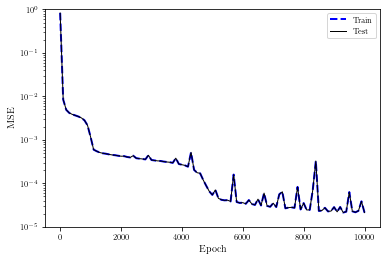

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


train_loss = np.array(train_loss_list)
test_loss =  np.array(test_loss_list)
plot_int = 100

ep = np.arange(0,nmax+1,1)
ep = ep[::plot_int]

train_loss_plot = train_loss[::plot_int]
test_loss_plot = train_loss[::plot_int]



gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_ylim([10**-5, 1])
ax.semilogy(ep, train_loss_plot, '--b', lw=2.0, label="Train")
ax.semilogy(ep, test_loss_plot, '-k', lw=1.0, label="Test")
plt.legend()
plt.savefig("Loss.png", dpi=300)
plt.show()




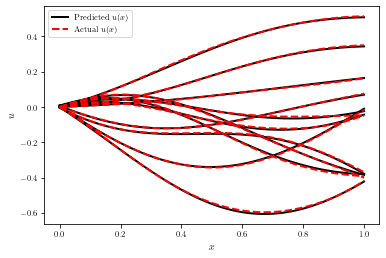

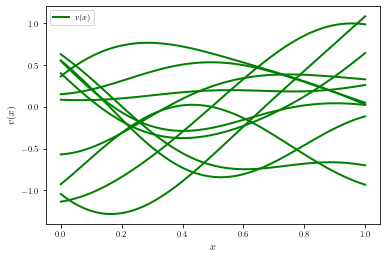

In [5]:
####
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])

ax1.plot(x_test, u_test_pred[20, :], '-k', lw=2.0, label="Predicted $u(x)$")

for i in range(10,20):
    ax1.plot(x_test, u_test_pred[i, :], '-k', lw=2.0)

ax1.plot(x_test, u_test[20, :], '--r', lw=2.0, label="Actual $u(x)$")

for i in range(10,20):
    ax1.plot(x_train,u_test[i, :], '--r', lw=2.0)



ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.legend(frameon=True, loc = 'best')
plt.savefig("predicted_and_deeponet.png", dpi=300)
plt.show()

####
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs2[:, :])

ax2.plot(x_test, v_test[20, :], '-g', lw=2.0, label="$v(x)$")
for i in range(10,20):
    ax2.plot(x_test, v_test[i, :], '-g', lw=2.0)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x)$')
ax2.legend(frameon=True, loc = 'best')
plt.savefig("forcing.png", dpi=300)

## PI-DeepONet for Antiderivative Operators in TF

In [18]:
import os
import time
import tensorflow as tf
import numpy as np
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
np.random.seed(1234)
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


class DNN:
    def __init__(self):
        pass
    #initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2.0/(in_dim+out_dim))
            weight = tf.Variable(tf.random.truncated_normal(shape=(in_dim, out_dim), stddev = std))
            bias = tf.Variable(tf.random.truncated_normal(shape=(1, out_dim), stddev = std))
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.nn.relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
    def fnn_T(self, X, W, b):
        A = X #2.*(X - Xmin)/(Xmax - Xmin) - 1.0
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
    
#Load Training Data
d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
v_train, x_train, u_train = d["X"][0], d["X"][1], d["y"]


d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
v_test, x_test, u_test = d["X"][0], d["X"][1], d["y"]

#input dimension for Branch Net
u_dim = 100

#output dimension for Branch and Trunk Net
G_dim = 100

#Branch Net
layers_f = [u_dim] + [40]*4 + [G_dim]

# Trunk dim
x_dim = 1

#Trunk Net
layers_x = [x_dim] + [40]*4 + [G_dim]

model = DNN()

@tf.function()
def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_branch, b_branch, W_trunk, b_trunk, x])
        u_out_branch = model.fnn_B(v, W_branch, b_branch)
        u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)       
        u_pred = tf.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
        loss_data = tf.reduce_mean(tf.square(u_pred - u))        
        loss_phys = 0.0
        #print(tf.shape(v))
        for i in range(0, 10):      
            u_p = u_pred[i]
            u_o = v[i]
            res = tape.gradient(u_p, x)
            loss_phys += tf.reduce_mean(tf.square(res - u_o))
            loss = loss_phys + loss_data
        grads = tape.gradient(loss, train_vars)
        opt.apply_gradients(zip(grads, train_vars))
        return loss_data, u_pred 

def test_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    x_test_tf = tf.convert_to_tensor(x, dtype=tf.float32)
    v_test_tf = tf.convert_to_tensor(v, dtype=tf.float32)
    u_test_tf = tf.convert_to_tensor(u, dtype=tf.float32)
    u_out_branch = model.fnn_B(v_test_tf, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x_test_tf, W_trunk, b_trunk)       
    u_pred = tf.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
    loss = tf.reduce_mean(tf.square(u_pred - u))        
    return loss, u_pred 

    
W_branch, b_branch = model.hyper_initial(layers_f)
W_trunk, b_trunk =   model.hyper_initial(layers_x)

n = 0
nmax = 10000
lr = 1e-4
start_time = time.perf_counter()
time_step_0 = time.perf_counter()
optimizer = tf.optimizers.Adam(learning_rate=lr)
                        
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

while n <= nmax:
    x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    v_train_tf = tf.convert_to_tensor(v_train, dtype=tf.float32)
    u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)
    loss_train, u_train_pred = train_step(model, W_branch, b_branch, W_trunk, \
                                          b_trunk, v_train_tf, x_train_tf, u_train_tf, \
                            optimizer)
    err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1)/\
                np.linalg.norm(u_train , 2, axis=1))
    
    loss_test, u_test_pred = test_step(model, W_branch, b_branch, W_trunk, b_trunk, v_test, x_test, u_test, \
                            optimizer)
    err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1)/\
            np.linalg.norm(u_test , 2, axis=1))
    
    if n % 100 == 0:
        print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
    train_err_list.append(err_train)
    test_err_list.append(err_test)
    train_loss_list.append(loss_train)
    test_loss_list.append(loss_test)     
    n = n + 1

    


Iteration: 0 Train_loss:0.2830564081668854, Test_loss: 0.31994444131851196
Iteration: 100 Train_loss:0.02918188087642193, Test_loss: 0.0321132093667984
Iteration: 200 Train_loss:0.009369079023599625, Test_loss: 0.010269196704030037
Iteration: 300 Train_loss:0.006596091669052839, Test_loss: 0.007138414774090052
Iteration: 400 Train_loss:0.005807717330753803, Test_loss: 0.006327952723950148
Iteration: 500 Train_loss:0.005491180811077356, Test_loss: 0.006012794096022844
Iteration: 600 Train_loss:0.005298244301229715, Test_loss: 0.0058204419910907745
Iteration: 700 Train_loss:0.005138158332556486, Test_loss: 0.005656723864376545
Iteration: 800 Train_loss:0.00499830162152648, Test_loss: 0.005502527579665184
Iteration: 900 Train_loss:0.004861714318394661, Test_loss: 0.005363975651562214
Iteration: 1000 Train_loss:0.004759318195283413, Test_loss: 0.005239566788077354
Iteration: 1100 Train_loss:0.00467836344614625, Test_loss: 0.0051446640864014626
Iteration: 1200 Train_loss:0.00461159367114305

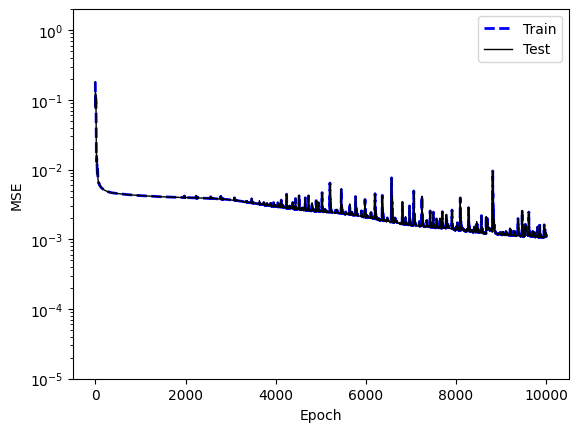

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


train_loss = np.array(train_loss_list)
test_loss =  np.array(test_loss_list)
plot_int = 1

ep = np.arange(0,nmax+1,1)
ep = ep[::plot_int]

train_loss_plot = train_loss[::plot_int]
test_loss_plot = train_loss[::plot_int]



gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_ylim([10**-5, 2])
ax.semilogy(ep, train_loss_plot, '--b', lw=2.0, label="Train")
ax.semilogy(ep, test_loss_plot, '-k', lw=1.0, label="Test")
plt.legend()
plt.savefig("Loss.png", dpi=300)
plt.show()



## DeepONet for Antiderivative Operators in JAX

In [8]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
from jax.example_libraries import optimizers
from jax import jit, grad, vmap, value_and_grad
from jax import random
import scipy.io as io
import time
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec


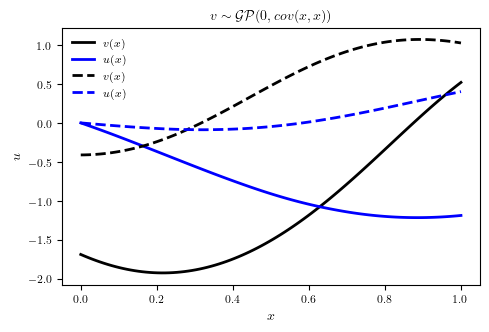

In [10]:
import numpy as np
import jax.numpy as jnp
# Load the data and visualize 
d = np.load("antiderivative_train.npz", allow_pickle=True)
v_train, x_train, u_train = jnp.array(d["X"][0]), \
jnp.array(d["X"][1]), jnp.array(d["y"])

d = np.load("antiderivative_test.npz", allow_pickle=True)
v_test, x_test, u_test = jnp.array(d["X"][0]),\
jnp.array(d["X"][1]), jnp.array(d["y"])

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1,1)
ax = plt.subplot(gs0[:, :])
ax.plot(x_train, v_train[10,:], '-k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_train[10,:], '-b', lw=2.0, label="$u(x)$")
ax.plot(x_train, v_test[100,:], '--k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_test[100,:], '--b', lw=2.0, label="$u(x)$")
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$v \sim \mathcal{GP}(0, cov(x,x))$', fontsize = 10)
plt.savefig("Data.png", dpi=300)
plt.show()

In [9]:
key = random.PRNGKey(1234)
initializer = jax.nn.initializers.glorot_normal()
def hyper_initial(layers):
    L = len(layers)
    W = []
    b = []
    for l in range(1, L):
        in_dim = layers[l-1]
        out_dim = layers[l]
        std = np.sqrt(2.0/(in_dim+out_dim))
        weight = initializer(key, (in_dim, out_dim), jnp.float32)*std
        bias = initializer(key, (1, out_dim), jnp.float32)*std
        W.append(weight)
        b.append(bias)
    return W, b
def fnn_B(X, W, b):
    inputs = X
    L = len(W)
    for i in range(L-1):
        outputs = jnp.dot(inputs, W[i]) + b[i]
        inputs = jnp.tanh(outputs)  
    Y = jnp.dot(inputs, W[-1]) + b[-1]     
    return Y

def fnn_T(X, W, b):
    inputs = X
    L = len(W)
    for i in range(L-1):
        outputs = jnp.dot(inputs, W[i]) + b[i]
        inputs = jnp.tanh(outputs)  # inputs to the next layer
    Y = jnp.dot(inputs, W[-1]) + b[-1]     
    return Y


def predict(params, data):
    W_branch, b_branch, W_trunk, b_trunk = params
    v, x = data
    u_out_branch = fnn_B(v, W_branch, b_branch) # predict on branch
    u_out_trunk = fnn_T(x, W_trunk, b_trunk) # predict on trunk
    u_pred = jnp.einsum('ik,jk->ik',u_out_branch, u_out_trunk) # matmul
    return u_pred

def loss(params, data, u):
    u_preds = predict(params, data)
    # print(u_preds)
    mse = jnp.mean(jnp.sum((u_preds - u)**2, axis = 1)) 
    # print(mse)
    return mse

@jit
def update(params, data, u, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, data, u)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value


#input dimension for Branch Net
u_dim = 100
#output dimension for Branch and Trunk Net
G_dim = 100
#Branch Net
layers_f = [u_dim] + [40]*2 + [G_dim]
# Trunk dim
x_dim = 1
#Trunk Net
layers_x = [x_dim] + [40]*2 + [G_dim]
W_branch, b_branch = hyper_initial(layers_f)
W_trunk, b_trunk =   hyper_initial(layers_x)
# Defining an optimizer in Jax
num_epochs = 10000
lr = 5e-4
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init([W_branch, b_branch, W_trunk, b_trunk])
params = get_params(opt_state)
train_loss, test_loss = [], []

start_time = time.time()

for epoch in range(num_epochs):
    params, opt_state, loss_val = update(params, [v_train, x_train], u_train, opt_state)
    train_loss.append(loss_val)
    if epoch % 100 ==0:
        epoch_time = time.time() - start_time
        u_train_pred = predict(params, [v_train, x_train])
        err_train = jnp.mean(jnp.linalg.norm(u_train - u_train_pred, 2, axis=1)/\
                             np.linalg.norm(u_train , 2, axis=1))
        u_test_pred = predict(params, [v_test, x_test])
        err_test = jnp.mean(jnp.linalg.norm(u_test - u_test_pred, 2, axis=1)/\
                            np.linalg.norm(u_test , 2, axis=1))
        test_loss_val = loss(params, [v_test, x_test], u_test)
        test_loss.append(test_loss_val)
        print("Epoch {} | T: {:0.6f} | Train MSE: {:0.4f} | \
        Test MSE: {:0.4f} | Train L2: {:0.4f} | Test L2: {:0.4f}"\
              .format(epoch, epoch_time, loss_val, test_loss_val, err_train, err_test))

NameError: name 'random' is not defined

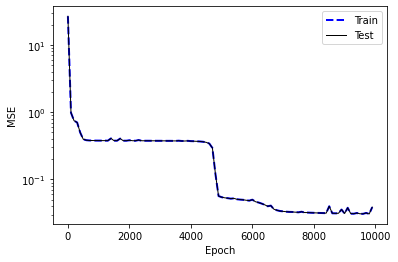

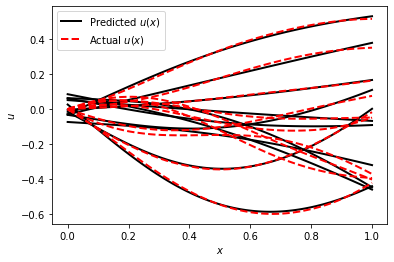

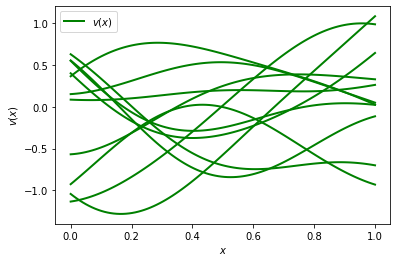

In [5]:
train_loss = np.array(train_loss)
test_loss =  np.array(test_loss)
plot_int = 100

ep = np.arange(0,num_epochs,1)
ep = ep[::plot_int]

train_loss_plot = train_loss[::plot_int]
test_loss_plot = train_loss[::plot_int]



gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
#ax.set_ylim([10**-5, 1])
ax.semilogy(ep, train_loss_plot, '--b', lw=2.0, label="Train")
ax.semilogy(ep, test_loss_plot, '-k', lw=1.0, label="Test")
plt.legend()
plt.savefig("Loss.png", dpi=300)
plt.show()



pred = predict(params, [v_train, x_train])
u_test_pred = predict(params, [v_test, x_test])

############################
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])

ax1.plot(x_test, u_test_pred[20, :], '-k', lw=2.0, label="Predicted $u(x)$")

for i in range(10,20):
    ax1.plot(x_test, u_test_pred[i, :], '-k', lw=2.0)

ax1.plot(x_test, u_test[20, :], '--r', lw=2.0, label="Actual $u(x)$")

for i in range(10,20):
    ax1.plot(x_train,u_test[i, :], '--r', lw=2.0)



ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.legend(frameon=True, loc = 'best')
plt.savefig("predicted_and_deeponet.png", dpi=300)
plt.show()

####
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs2[:, :])

ax2.plot(x_test, v_test[20, :], '-g', lw=2.0, label="$v(x)$")
for i in range(10,20):
    ax2.plot(x_test, v_test[i, :], '-g', lw=2.0)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x)$')
ax2.legend(frameon=True, loc = 'best')
plt.savefig("forcing.png", dpi=300)

## Fourier Neural Operator (FNO) for Burgers Equation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from op_utilities import *
from torch.optim import Adam

torch.manual_seed(0)
np.random.seed(0)


################################################################
#  Fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, dtype=torch.cfloat))
    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  \
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        print(x.shape)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 2#500
step_size = 50
gamma = 0.5

modes = 16
width = 64

dataloader = MatReader('/Users/raj/Desktop/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train),\
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),\
                                          batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width)
print(count_params(model))
################################################################
# Training and Prediction
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x, y 
        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x, y 

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    t2 = default_timer()
    print(f"Epoch: {ep}, Epoch Time: {t2-t1}, Train MSE_Error: {train_mse}, Train_L2_Error :{train_l2}\
    Test L2 Error, {test_l2}")

# torch.save(model, 'model/ns_fourier_burgers')
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),\
                                          batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x, y

        out = model(x).view(-1)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


549569
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch.Size([20, 1024, 1])
torch

In [2]:
s

1024

In [17]:
scipy.io.savemat('burger_test.mat', mdict={'pred': pred.cpu().numpy()})

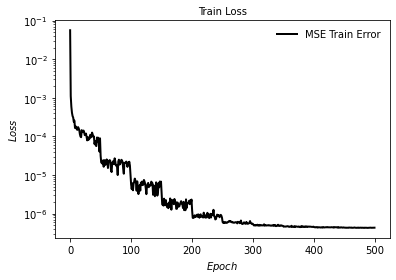

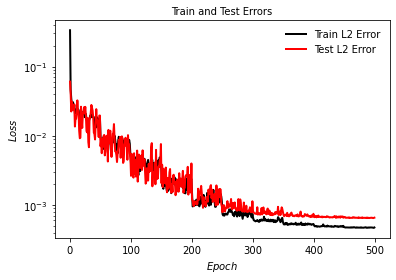

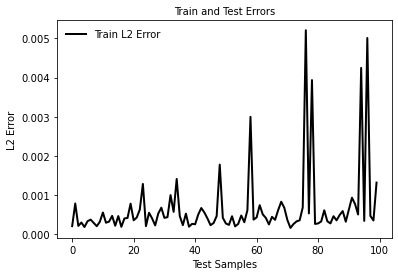

In [47]:
import matplotlib.gridspec as gridspec
ep,t, e_mse, trn_l2, tst_l2 = np.loadtxt("loss_err_fno.txt", delimiter=' ', usecols=(0, 1,2,3,4), unpack=True)
gs0 = gridspec.GridSpec(1,1)
ax = plt.subplot(gs0[:, :])
ax.semilogy(ep, e_mse, '-k', lw=2.0, label="MSE Train Error")
ax.set_xlabel('$Epoch$')
ax.set_ylabel('$Loss$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Train Loss', fontsize = 10)
plt.savefig("Train_Loss.png", dpi=300)

plt.show()
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])
ax1.semilogy(ep, trn_l2, '-k', lw=2.0, label="Train L2 Error")
ax1.semilogy(ep, tst_l2, '-r', lw=2.0, label="Test L2 Error")

ax1.set_xlabel('$Epoch$')
ax1.set_ylabel('$Loss$')
ax1.legend(frameon=False, loc = 'best')
ax1.set_title('Train and Test Errors', fontsize = 10)
plt.savefig("Train_Test.png", dpi=300)

plt.show()

ba,e = np.loadtxt("eval_err.txt", delimiter=' ', usecols=(0, 1), unpack=True)
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs1[:, :])
ax2.plot(ba, e, '-k', lw=2.0, label="Train L2 Error")

ax2.set_xlabel('Test Samples')
ax2.set_ylabel("L2 Error")
ax2.legend(frameon=False, loc = 'best')
ax2.set_title('Train and Test Errors', fontsize = 10)
plt.savefig("Error.png", dpi=300)

plt.show()


L2 Error is: 0.00020575149392243475


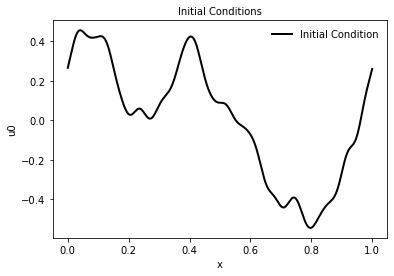

In [76]:
pred_u_plot = pred[0,:]
u_test_plot = y_test[0,:]
x_test_plot = x_test[0,:]
x_plot = np.linspace(0, 1, 1024)
err1 = np.linalg.norm(u_test_plot - pred_u_plot)
err2 = np.linalg.norm(u_test_plot)
err = err1/err2
print(f"L2 Error is: {err}")
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.plot(x_plot, pred_u_plot, '-k', lw=2.0, label="FNO Predicted")
ax.plot(x_plot, u_test_plot, '--b', lw=2.0, label="Actual Solution")
ax.set_xlabel('$x$')
ax.set_ylabel("u")
ax.legend(frameon=False, loc = 'best')
ax.set_title("Actual vs Predicetd $u$, T=1 with L2 Error = 0.0002", fontsize = 10)
plt.savefig("Solution", dpi=300)


gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[:, :])
ax1.plot(x_plot, x_test_plot, '-k', lw=2.0, label="Initial Condition")
ax1.set_xlabel('x')
ax1.set_ylabel("u0")
ax1.legend(frameon=False, loc = 'best')
ax1.set_title("Initial Conditions", fontsize = 10)
plt.savefig("Ic_test", dpi=300)
plt.show()


tensor([0.1210, 0.1235, 0.1259,  ..., 0.1138, 0.1163, 0.1188])

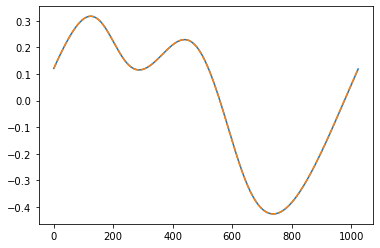

In [50]:
plt.plot(s1, "-")
plt.plot(s2,"--")